# **Fingerprint thinning**

In [1]:
from KMM import KMM
from morphology import morphology_thinning
import numpy as np
from PIL import Image
import cv2
from IPython.display import display
import matplotlib.pyplot as plt

In [2]:
def perform_thinning(
    path: str, 
    show_by_iterations: bool = False, 
    algorithm: str = 'KMM',
    show: bool = True,
    correct_original: bool = True,
    correct_thinning: bool = True
    ) -> np.ndarray:
    
    algs = {
        'KMM': KMM,
        'morphology': morphology_thinning
    }
    
    if algorithm not in algs:
        raise ValueError(f"Unknown algorithm: {algorithm}. Available algorithms: {list(algs.keys())}")

    alg = algs[algorithm]
    farray = read_bmp(path)
    
    if show:
        img = Image.fromarray(farray)
        print("Original Image")
        display(img)
    
    if correct_original:
        farray = correct_orig(farray)
        if show:
            img = Image.fromarray(farray)
            print("\nCorrected Original Image")
            display(img)
    
    skeleton = alg(farray, show=show_by_iterations)

    if show:
        img_skeleton = skeleton.copy()
        img_skeleton[skeleton == 0] = 255
        img_skeleton[skeleton == 1] = 0
        img_skeleton = img_skeleton.astype(np.uint8)
        img = Image.fromarray(img_skeleton)
        print("\nThinned Image")
        display(img)  
        
    if correct_thinning:
        skeleton = correct(skeleton)    
        img_skeleton = skeleton.copy()
        img_skeleton[skeleton == 0] = 255
        img_skeleton[skeleton == 1] = 0


        img_skeleton = img_skeleton.astype(np.uint8)
        img = Image.fromarray(img_skeleton)
        print("\nThinned Image after Morphological Correction")
        display(img) 
      
    return skeleton

    
def read_bmp(path: str) -> np.ndarray:
    image = Image.open(path)
    image_np = np.array(image)
    _, farray = cv2.threshold(image_np, 127, 255, cv2.THRESH_BINARY)
    if farray.ndim == 3:
        farray = farray[:, :, 0]
    return farray


def correct(skeleton: np.ndarray) -> np.ndarray:
    skeleton = (skeleton > 0).astype(np.uint8)
    out = skeleton.copy()
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 2))
    out = cv2.morphologyEx(out, cv2.MORPH_DILATE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_DILATE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 2))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 2))
    out = cv2.morphologyEx(out, cv2.MORPH_DILATE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_DILATE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 2))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    return out

def correct_orig(farray: np.ndarray) -> np.ndarray:
    # TODO: implement the function to correct the original image
    result = farray.copy()
    return result

# **Example**

Original Image


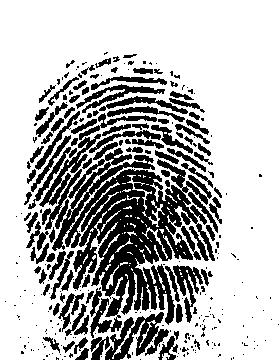

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8

Thinned Image


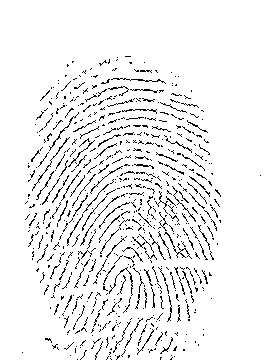


Thinned Image after Morphological Correction


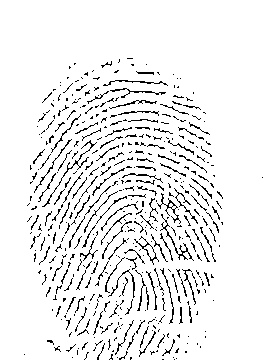

In [11]:
tester = 'data/palec44.bmp'
skeleton = perform_thinning(path=tester, 
                            show_by_iterations=False,
                            show=True, 
                            algorithm='morphology',
                            correct_original=False,
                            correct_thinning=True)

# **Minutiae detection**

In [12]:
def detect_minutiae(skel: np.ndarray, show: bool = True) -> dict:
    assert skel.dtype == np.uint8 and set(np.unique(skel)).issubset({0,1})
    h, w = skel.shape
    padded = np.pad(skel, ((1, 1), (1, 1)), mode='constant', constant_values=0)
    minutiae = {}
    for i in range(1, h + 1):
        for j in range(1, w + 1):
            if padded[i, j] == 1:
                neighborhood = padded[i - 1:i + 2, j - 1:j + 2]
                sum = np.sum(neighborhood)
                if sum == 2:
                    add_ending(i, j, padded, minutiae)
                elif sum == 4:
                    add_bifurcation(i, j, padded, minutiae)

    if show:
        show_minutiae(skel, minutiae)
        
    return minutiae


def add_bifurcation(i: int, j: int, padded: np.ndarray, minutiae: dict) -> None:
    neighbors = [(0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1), (1, 0), (1, 1)]
    count = 1
    ones = []
    neighborhood = padded[i - 1:i + 2, j - 1:j + 2]
    for x_neighbor, y_neighbor in neighbors:
        if padded[i + x_neighbor, j + y_neighbor] == 1:
            ones.append(count)
            if x_neighbor == 1 and y_neighbor == 1:
                ones.append(0)
        count += 1
    
    mod_diffs = np.abs(np.diff(ones))
    last_first_diff = np.abs(ones[-1] - ones[0])
    full_diffs = np.append(mod_diffs, last_first_diff) 
    if 1 in full_diffs:
        return
    if ones == [1, 4, 7]:
      split_index = 2  
    else:
        split_index = np.where(full_diffs == 2)[0][0]
    direction = split_index
    direction_angle = ones[direction]
    angle = (45 * direction_angle) % 360
    minutiae[(i, j)] = {
        'type': 'bifurcation',
        'direction': angle
    }


def add_ending(i: int, j: int, padded: np.ndarray, minutiae: dict) -> None:
    neighbors = [(0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1), (1, 0), (1, 1)]
    neighborhood = padded[i - 1:i + 2, j - 1:j + 2]

    counter = 0
    for x_neighbor, y_neighbor in neighbors:
        if padded[i + x_neighbor, j + y_neighbor] == 1:
            angle = (180 + 45 * counter) % 360
            break
        counter += 1
    minutiae[(i, j)] = {
        'type': 'ending',
        'direction': angle
    }
    
    
def show_minutiae(skel: np.ndarray, minutiae: dict) -> None:
    h, w = skel.shape
    base = np.full((h, w, 3), 255, np.uint8)  
    base[skel == 1] = (0, 0, 0)  
    vis = base.copy()

    for (i, j), data in minutiae.items():
        typ = data['type']
        angle = data['direction']

        if typ == 'ending':
            color = (0, 0, 255)  
        elif typ == 'bifurcation':
            color = (255, 0, 0)  

        cv2.circle(vis, (j, i), 2, color, thickness=-1)

        length = 8

        dx = int(length * np.cos(np.radians(angle)))
        dy = int(-length * np.sin(np.radians(angle)))  

        end_point = (j + dx, i + dy)

        cv2.arrowedLine(vis, (j, i), end_point, color, thickness=1, tipLength=0.3)

    plt.figure(figsize=(10, 10))
    plt.imshow(vis[..., ::-1])  
    plt.axis('off')
    plt.show()

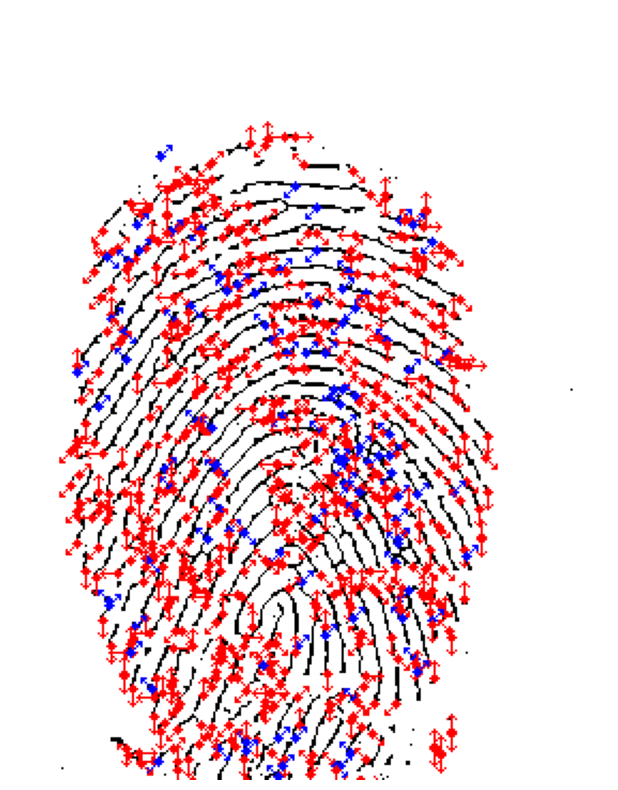

{(59, 128): {'type': 'ending', 'direction': 180},
 (59, 133): {'type': 'ending', 'direction': 0},
 (60, 120): {'type': 'ending', 'direction': 90},
 (62, 112): {'type': 'ending', 'direction': 90},
 (63, 119): {'type': 'ending', 'direction': 225},
 (68, 70): {'type': 'bifurcation', 'direction': 45},
 (71, 94): {'type': 'ending', 'direction': 45},
 (72, 93): {'type': 'ending', 'direction': 225},
 (72, 137): {'type': 'ending', 'direction': 135},
 (75, 160): {'type': 'ending', 'direction': 315},
 (78, 82): {'type': 'ending', 'direction': 135},
 (79, 83): {'type': 'ending', 'direction': 315},
 (79, 94): {'type': 'ending', 'direction': 180},
 (81, 79): {'type': 'ending', 'direction': 0},
 (82, 76): {'type': 'ending', 'direction': 180},
 (82, 133): {'type': 'bifurcation', 'direction': 225},
 (84, 73): {'type': 'ending', 'direction': 45},
 (85, 87): {'type': 'ending', 'direction': 45},
 (86, 168): {'type': 'ending', 'direction': 315},
 (86, 175): {'type': 'ending', 'direction': 90},
 (88, 95): 

In [13]:
detect_minutiae(skeleton, show=True)